# Demo: GPSR Using Bingo

## (1) Import Base Packages ##

In [2]:
import numpy as np;np.seterr(all="ignore")
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import display, clear_output
from tqdm import tqdm

## (2) Import Relevant Bingo Classes ##

In [3]:
#Classes for Genetic Programming (GP)
from bingo.symbolic_regression import ComponentGenerator
from bingo.evolutionary_optimizers.island import Island
from bingo.symbolic_regression.agraph.agraph import AGraph
from bingo.stats.pareto_front import ParetoFront

#Classes for the EVALUATION stage of GPSR
from bingo.symbolic_regression import ExplicitRegression, \
                                      ExplicitTrainingData
from bingo.evaluation.evaluation import Evaluation
from bingo.local_optimizers.continuous_local_opt import ContinuousLocalOptimization

#Classes for the EVOLUTION stage of GPSR
from bingo.symbolic_regression import AGraphGenerator, \
                                      AGraphCrossover, \
                                      AGraphMutation

#Classes for the SELECTION stage of GPSR
from bingo.evolutionary_algorithms.generalized_crowding import \
                                      GeneralizedCrowdingEA
from bingo.selection.deterministic_crowding import DeterministicCrowding

## (2) Initialize GPSR Hyperparameters ##
Note: Hyperparameters relating to the criterion check and information storage not present in this code. Refer to BingoExample/example_code/main_script.py for additional information.

In [5]:
POPULATION_SIZE = 104
STACK_SIZE = 24
MAX_GENERATIONS = 100

## (3) Make Training Data ##

<IPython.core.display.Javascript object>


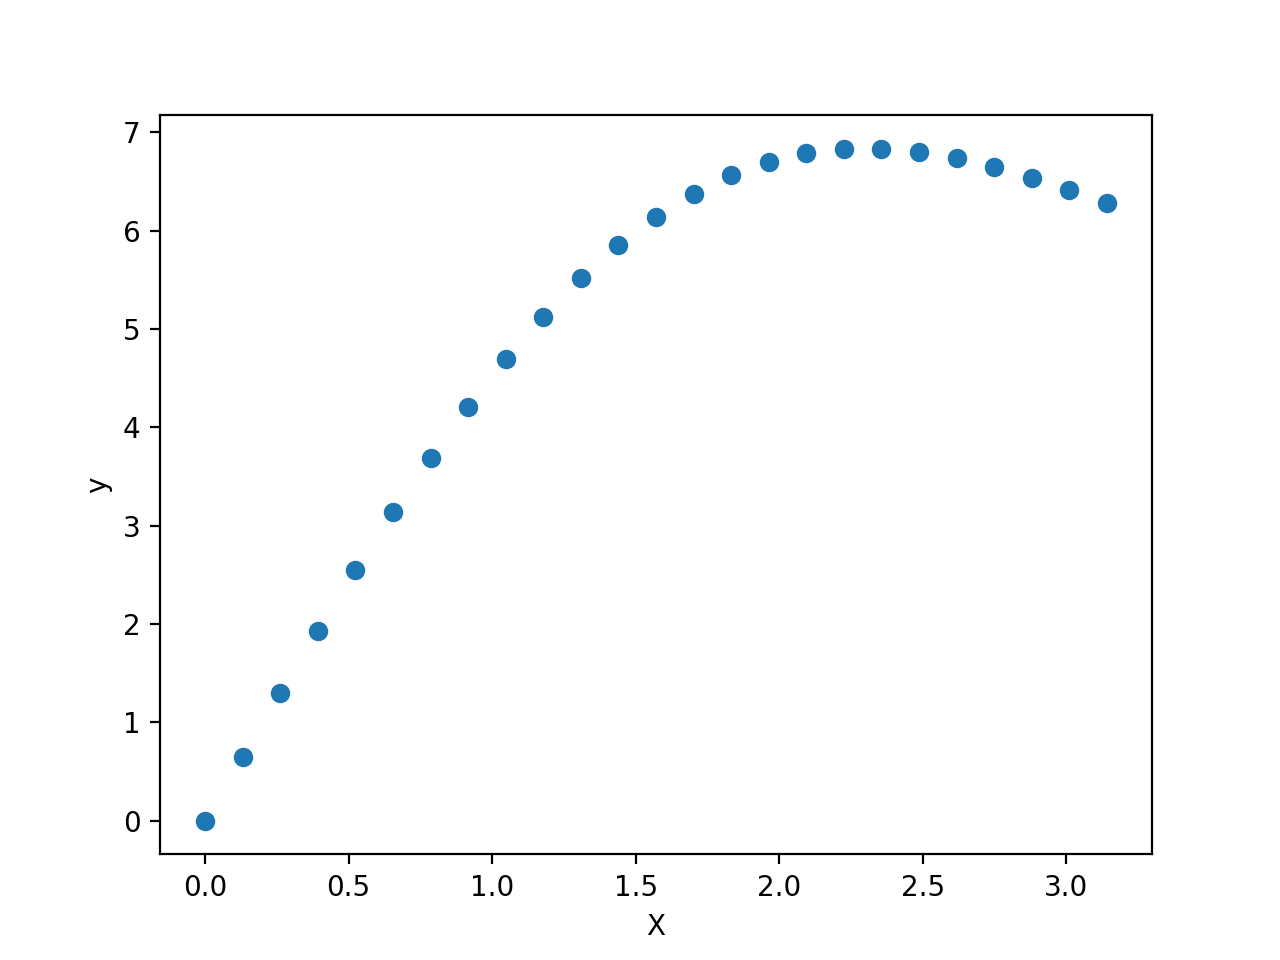

Text(0, 0.5, 'y')

In [7]:
model = AGraph(equation="3*sin(X_0) + 2*X_0")
X = np.linspace(0, np.pi, 25).reshape((-1,1))
y = model.evaluate_equation_at(X)
training_data = ExplicitTrainingData(x=X, y=y)
plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")

## (4) Initialize component generator, mutation and crossover objects, and AGraph generators ##

In [9]:
component_generator = ComponentGenerator(training_data.x.shape[1])
component_generator.add_operator("+")
component_generator.add_operator("-")
component_generator.add_operator("*")
component_generator.add_operator("sin")
component_generator.add_operator("cos")

crossover = AGraphCrossover()
mutation = AGraphMutation(component_generator)
agraph_generator = AGraphGenerator(STACK_SIZE, component_generator,
                                       use_simplification=True)

## (5) Initialize fitness metric, parameter optimizer, and evaluator ##

In [11]:
fitness = ExplicitRegression(training_data=training_data)
local_opt_fitness = ContinuousLocalOptimization(fitness, algorithm='lm')
evaluator = Evaluation(local_opt_fitness)

## (6) Initialize selection and evolutionary algorithm ##

In [12]:
selection_phase = DeterministicCrowding()
ea = GeneralizedCrowdingEA(evaluator, crossover,
                      mutation, 0.4, 0.4, selection_phase)

## (7) Initialize Bingo Island with Hall of Fame ##

In [13]:
def agraph_similarity(ag_1, ag_2):
    """a similarity metric between agraphs"""
    return ag_1.fitness == ag_2.fitness and ag_1.get_complexity() == ag_2.get_complexity()

pareto_front = ParetoFront(secondary_key=lambda ag: ag.get_complexity(),
                           similarity_function=agraph_similarity) 
def make_island():
    """
    Function created for repeated runs.
    """
    island = Island(ea, agraph_generator, POPULATION_SIZE, hall_of_fame=pareto_front)
    return island

## (8) Run GPSR and Visualize Results ##

In [14]:
# Simple Visualization Code

def plot_best_n_individuals(ax, island, n=10):
    ax.clear()
    fits = np.array([ind.fitness for ind in island.population])
    fits[np.isinf(fits)] = np.nan
    idxs = np.argsort(fits)[:n]
    for i in idxs:
        ind = island.population[i]
        ax.plot(X, ind.evaluate_equation_at(X)) 
    ax.scatter(X, y, color="k", label="Training Data")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_ylim(0, 10)
    
def update_ax(ax, fig, x, y_mu, y_upper, y_lower):
    ax.clear()
    ax.set_ylim(0, 2.5)
    ax.set_xlabel("Generations")
    ax.set_ylabel("Mean Fitness")
    ax.plot(x, y_mu, color="b")
    ax.fill_between(x, y_upper, y_lower, color="b", alpha=0.3)
    

<IPython.core.display.Javascript object>


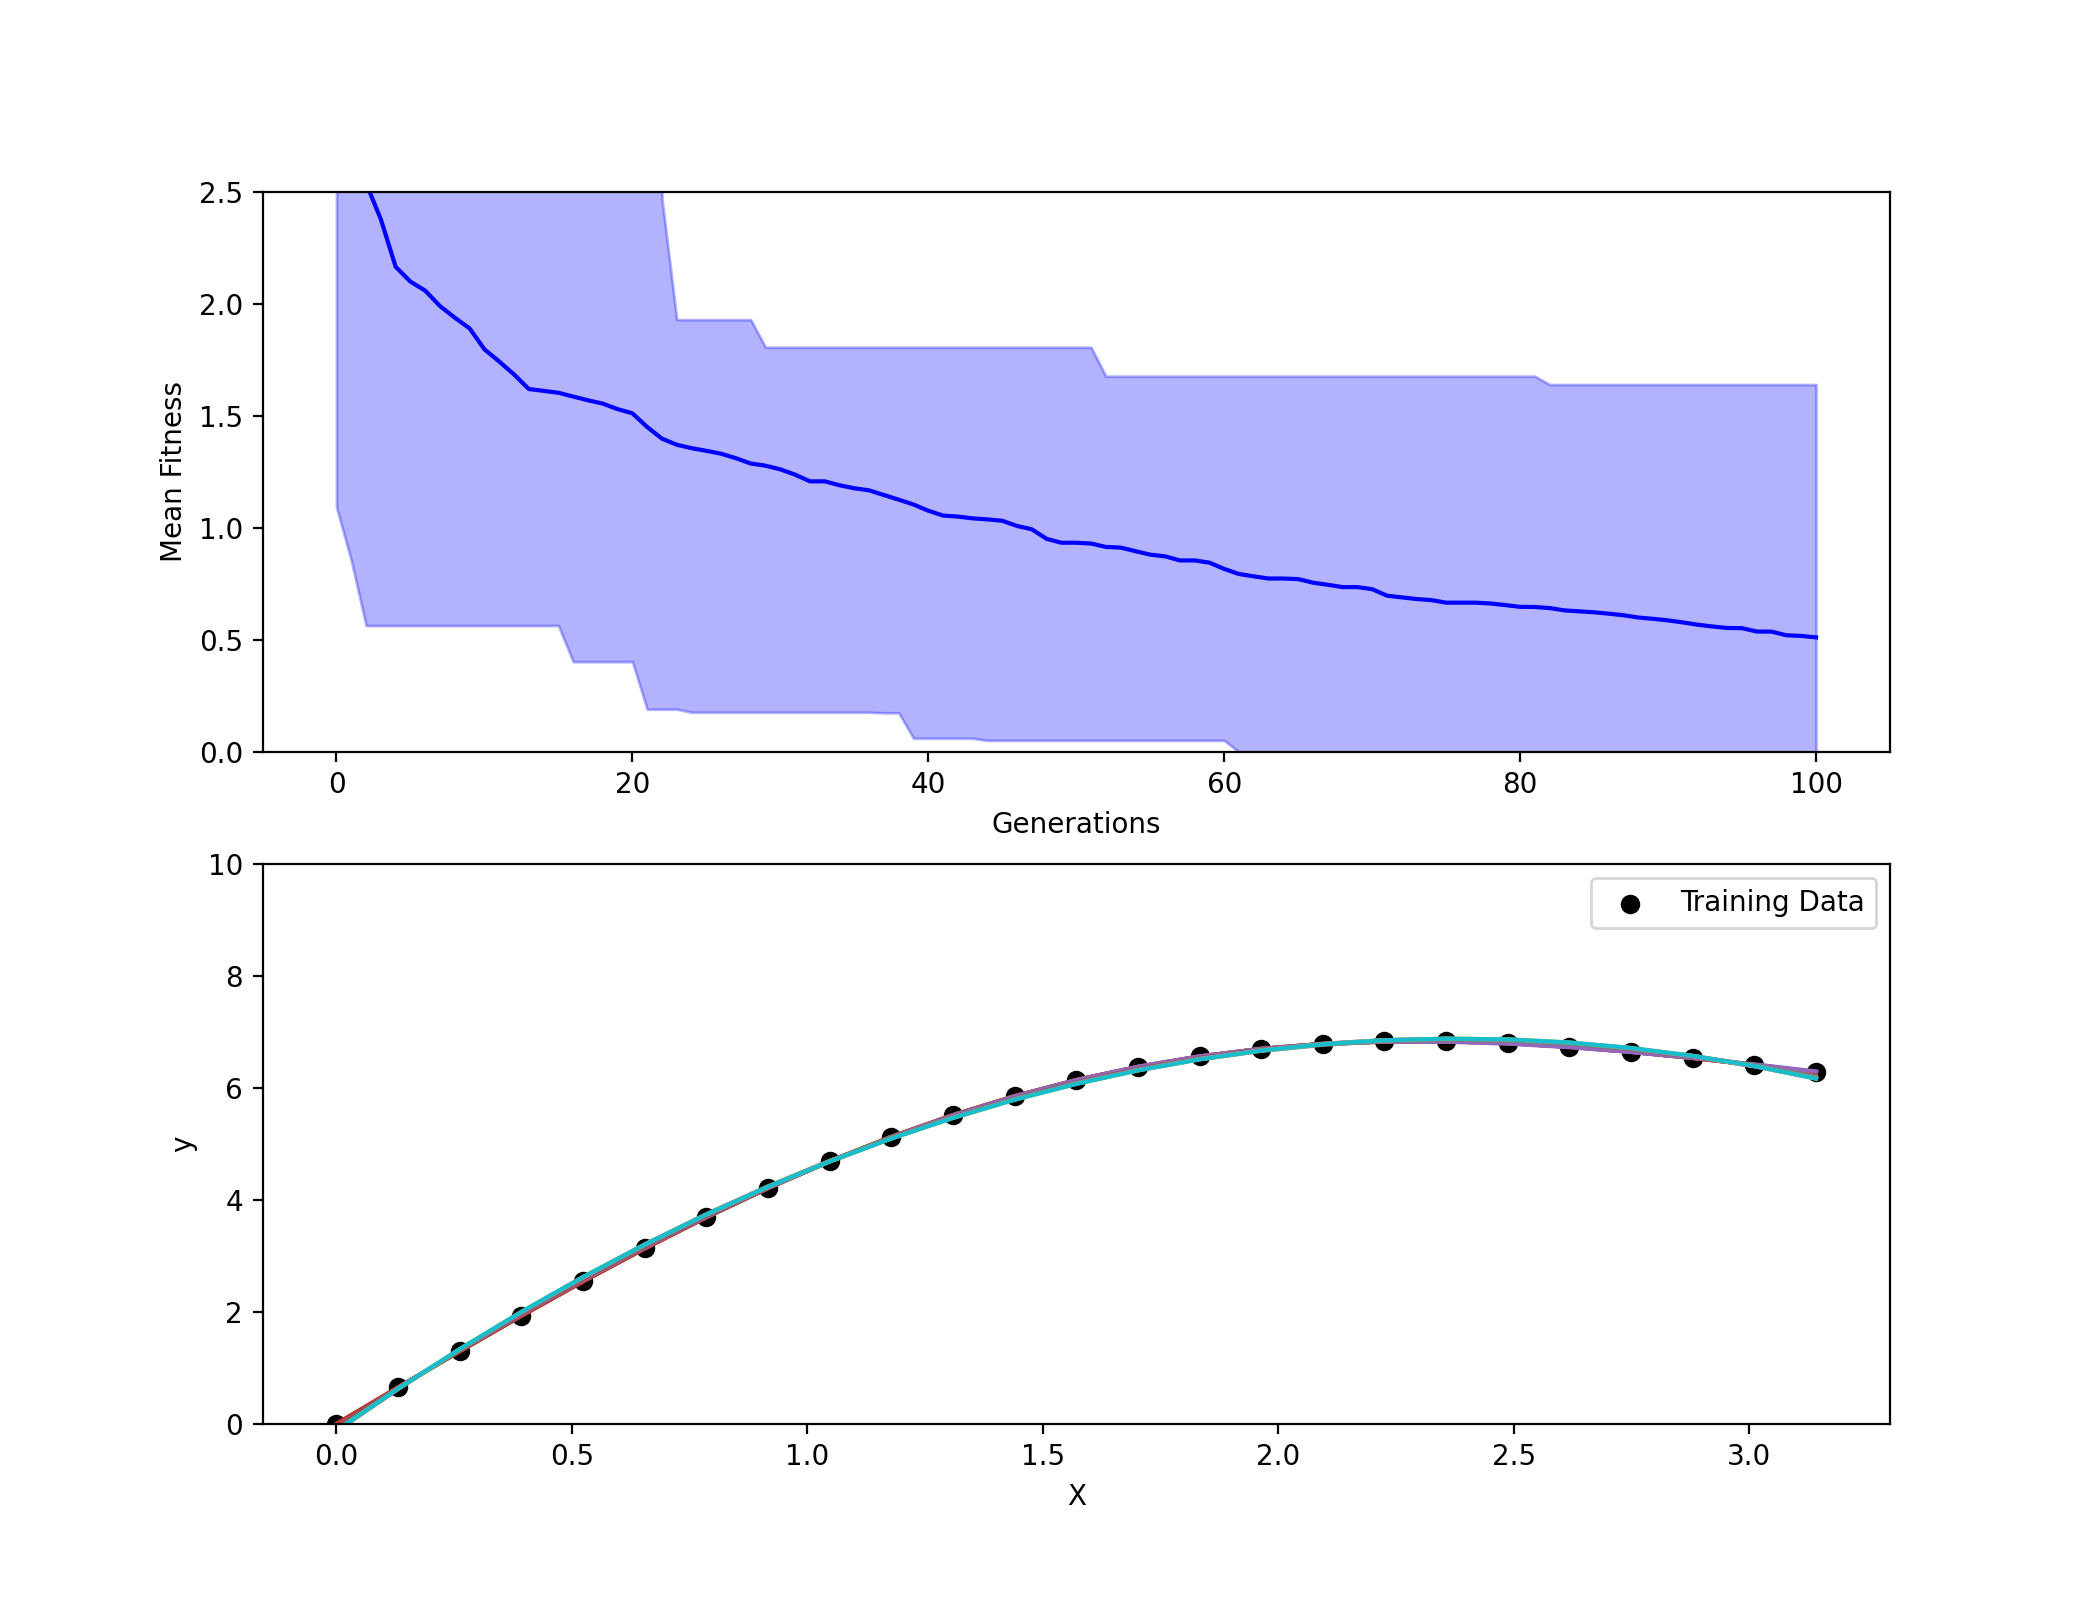

Text(0, 0.5, 'y')

In [15]:
fig, axs = plt.subplots(2, figsize=(10.5, 8))
axs[0].set_ylim(0, 1)
axs[1].scatter(X, y, color="k", label="Training Data")
axs[1].legend()
axs[0].set_ylim(0, 2.5)
axs[0].set_xlabel("Generations")
axs[0].set_ylabel("Mean Fitness")
axs[1].set_ylim(0, 10)
axs[1].set_xlabel("X")
axs[1].set_ylabel("y")

In [16]:
island = make_island()
#fig, axs = plt.subplots(2, figsize=(10.5, 8))
plt.show()
axs[0].set_xlabel("X")
axs[0].set_ylabel("y")

print("Best individual at initialization\n f(X_0) =", island.get_best_individual())
best_indv_values = []
best_indv_values.append(island.get_best_individual())
best_indv_gen = []
best_indv_gen.append(island.generational_age)
fits = [ind.fitness for ind in island.population]
means = [np.nanmean(fits)]
maxs = [np.nanmax(fits)]
mins = [np.nanmin(fits)]
fig.canvas.draw()

for i in tqdm(range(MAX_GENERATIONS)):
    island.evolve(1)
    best_indv = island.get_best_individual()
    if best_indv.fitness < best_indv_values[-1].fitness:
        best_indv_values.append(best_indv)
        best_indv_gen.append(island.generational_age)
        print(f"Best individual at generation {island.generational_age}\n f(X_0) =", island.get_best_individual())
    fits = np.array([ind.fitness for ind in island.population])
    fits[np.isinf(fits)] = np.nan
    means += [np.nanmean(fits)]
    maxs += [np.nanmax(fits)]
    mins += [np.nanmin(fits)]
    update_ax(axs[0], fig, np.arange(island.generational_age+1), np.array(means), np.array(maxs), np.array(mins))
    plot_best_n_individuals(axs[1], island, n=10)
    fig.canvas.draw()


Best individual at initialization
 f(X_0) = 3.4016425293867614 + X_0


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Best individual at generation 1
 f(X_0) = 1.8308462025918648 + (2.0)(X_0)


  2%|▊                                          | 2/100 [00:00<00:27,  3.60it/s]

Best individual at generation 2
 f(X_0) = cos((X_0)(X_0)) + (2.1129278774201525 + cos(X_0))((cos(cos(X_0)))((X_0)(X_0) + cos(cos(X_0))))


 15%|██████▎                                   | 15/100 [00:03<00:19,  4.37it/s]

Best individual at generation 16
 f(X_0) = 0.6368626880973849 + (3.189742890238798)(X_0) + (X_0)(cos(X_0))


 19%|███████▉                                  | 19/100 [00:04<00:18,  4.43it/s]

Best individual at generation 19
 f(X_0) = 0.6368626880973842 + (3.1897428902387985)(X_0) + (X_0)(cos(X_0))


 20%|████████▍                                 | 20/100 [00:04<00:19,  4.06it/s]

Best individual at generation 21
 f(X_0) = -0.9352918350431516 + (2)(X_0) + (X_0)(3.8990065015495654 - (X_0)) + cos(X_0)


 24%|██████████                                | 24/100 [00:05<00:18,  4.08it/s]

Best individual at generation 24
 f(X_0) = 0.2544510551956467 + (X_0)(5.141592653589794 - (X_0))


 30%|████████████▌                             | 30/100 [00:07<00:17,  3.91it/s]

Best individual at generation 30
 f(X_0) = 0.25445105519564637 + (X_0)(5.141592653589794 - (X_0))


 33%|█████████████▊                            | 33/100 [00:08<00:17,  3.75it/s]

Best individual at generation 34
 f(X_0) = 0.25445105519569083 + (-240.92149438902322)(X_0) + (X_0)(246.06308704261306 - (X_0))


 37%|███████████████▌                          | 37/100 [00:09<00:15,  3.95it/s]

Best individual at generation 37
 f(X_0) = (2)(X_0) + (2)(sin(X_0)) + sin(cos(cos(X_0)))


 38%|███████████████▉                          | 38/100 [00:09<00:15,  3.93it/s]

Best individual at generation 39
 f(X_0) = 1.032767503810031 + (2)(X_0) + sin(X_0) + cos((-1.605357268491522)(-1.5707963267943634 + X_0))


 43%|██████████████████                        | 43/100 [00:10<00:13,  4.12it/s]

Best individual at generation 44
 f(X_0) = -0.11648665928861585 + (3)(X_0) + ((2)((1.1114439130685627)(1.1114439130685627)))(X_0) - ((X_0)(-0.41021804900163866 + ((1.1114439130685627)(1.1114439130685627))(X_0)))


 61%|█████████████████████████▌                | 61/100 [00:15<00:11,  3.51it/s]

Best individual at generation 61
 f(X_0) = 4.750327952956654 + (2)(X_0) + (3.0)(-1.5834426509855515 + sin(X_0))


 83%|██████████████████████████████████▊       | 83/100 [00:21<00:04,  3.63it/s]

Best individual at generation 83
 f(X_0) = 0.6922443524623355 + (2)(X_0) + (3.0)(-0.23074811748744517 + sin(X_0))


100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


## Print Hall of Fame ###

In [18]:
for ind in island.hall_of_fame:
    print(f"model (fitness={ind.fitness}), fitness: {str(ind)}, {ind.fitness}")
    print()

model (fitness=0.0), fitness: 0.6922443524623355 + (2)(X_0) + (3.0)(-0.23074811748744517 + sin(X_0)), 0.0

model (fitness=5.454675823403983e-16), fitness: 7.245580006034719e-16 + sin(-1.7385568001930266e-16 + X_0) + (1.9999999999999996)(X_0 + sin(-1.7385568001930266e-16 + X_0)), 5.454675823403983e-16

model (fitness=0.051638189660022205), fitness: (-1.2353075718971562)((0.019890958505190702 - (X_0))(4.740731680409186 - (X_0))), 0.051638189660022205

model (fitness=0.17766858292807297), fitness: 0.25445105519564637 + (X_0)(5.141592653589794 - (X_0)), 0.17766858292807297

model (fitness=0.7886548459136473), fitness: (2.5956163358575677)(X_0) + sin(X_0), 0.7886548459136473

model (fitness=1.0897909409863533), fitness: 4.265038170218455 + X_0, 1.0897909409863533

model (fitness=1.6776956031577768), fitness: 5.582720923712278, 1.6776956031577768

